In [3]:
# --- 1. Load datasets ---
df_cleaned_data = pd.read_csv("merged_cleandata.csv")
df_patient_data = pd.read_csv("demographic_cleandata.csv")

# --- 2. Convert time to datetime ---
df_cleaned_data["time"] = pd.to_datetime(df_cleaned_data["time"])

# --- 3. Merge on patient ID ---
merged_data = df_cleaned_data.merge(
    df_patient_data,
    left_on="patient_id",
    right_on="patient_id",
    how="inner"
)

# --- 4. Set MultiIndex with (patient_id, time) ---
merged_data = merged_data.set_index(["patient_id", "time"]).sort_index()


print(merged_data.index.names)   # should show ['patient_id', 'time']
type(merged_data)

['patient_id', 'time']


pandas.core.frame.DataFrame

<b> 1. How much should patients increase their daily steps to reduce insulin needs?  </b> 


                              OLS Regression Results                              
Dep. Variable:     bolus_volume_delivered   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                     42.69
Date:                    Sun, 24 Aug 2025   Prob (F-statistic):           6.43e-11
Time:                            21:01:52   Log-Likelihood:            -3.5206e+05
No. Observations:                  309392   AIC:                         7.041e+05
Df Residuals:                      309390   BIC:                         7.041e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

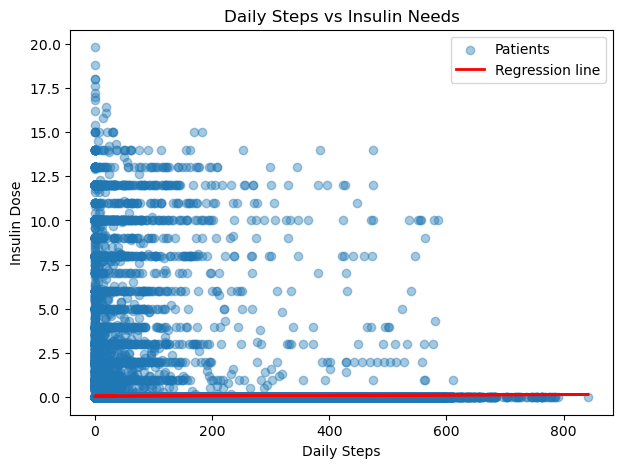

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load merged dataset (already has daily_steps + insulin_dose)
df = pd.read_csv("merged_cleandata.csv")

# Keep only rows with both steps + insulin
#df = df.dropna(subset=["daily_steps", "insulin_dose"])

# -------------------
# Linear regression: insulin_dose ~ daily_steps
# -------------------
X = sm.add_constant(df_cleaned_data["steps"])   # add intercept
y = df_cleaned_data["bolus_volume_delivered"]

model = sm.OLS(y, X).fit()
print(model.summary())

coef = model.params["steps"]
print(f"\nEstimated effect: Each additional 1,000 steps reduces insulin need by {coef*1000:.2f} units (approx).")

# Visualization
# -------------------
plt.figure(figsize=(7,5))
plt.scatter(df_cleaned_data["steps"], df_cleaned_data["bolus_volume_delivered"], alpha=0.4, label="Patients")
plt.plot(df_cleaned_data["steps"], model.predict(X), color="red", linewidth=2, label="Regression line")
plt.xlabel("Daily Steps")
plt.ylabel("Insulin Dose")
plt.title("Daily Steps vs Insulin Needs")
plt.legend()
plt.show()


Nighttime glucose spike rate by sleep duration group (age > 50):
     sleep_group  night_spike_rate
0    Short (<6h)          0.149048
1  Normal (6–8h)          0.464889


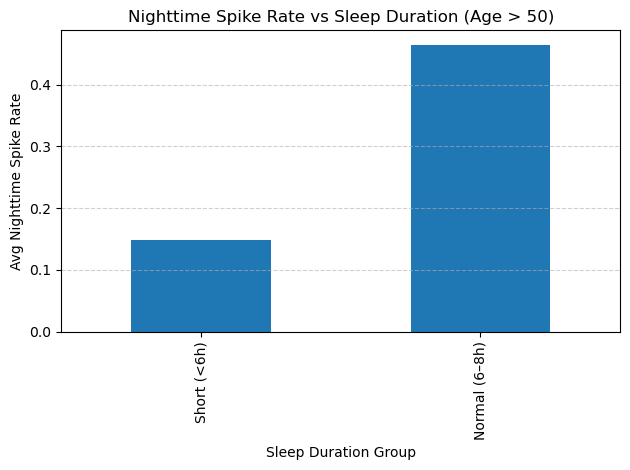


Per-patient nighttime spike summary & recommendation (age > 50):
  patient_id  avg_sleep_h  night_spike_rate  \
5  HUPA0017P          5.8          0.702128   
4  HUPA0014P          6.4          0.547244   
2  HUPA0009P          6.6          0.456731   
1  HUPA0007P          7.1          0.390551   
7  HUPA0024P          5.9          0.330208   
0  HUPA0003P          5.3          0.279528   
6  HUPA0023P          5.1          0.270455   
3  HUPA0011P          5.6          0.214961   
8  HUPA0027P          5.5          0.138092   
9  HUPA0028P          5.1          0.076157   

                                      recommendation  
5  Try +1 hour sleep/night and re-check nighttime...  
4  Try +1 hour sleep/night and re-check nighttime...  
2  Try +1 hour sleep/night and re-check nighttime...  
1  Night spikes elevated—evaluate sleep quality/t...  
7  Try +1 hour sleep/night and re-check nighttime...  
0             Consider increasing sleep towards 7–8h  
6             Consider increasi

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load & merge
# -----------------------------
demo   = pd.read_csv("demographic_cleandata.csv")
merged = pd.read_csv("merged_cleandata.csv", parse_dates=["time"])

# Keep only what we need from demographics
demo_keep = demo[["patient_id", "age", "sleep_duration"]]  # sleep_duration = hours/night
df = merged.merge(demo_keep, on="patient_id", how="left")

# -----------------------------
# 2) Filter: older adults
# -----------------------------
df = df[df["age"] > 50].copy()

# -----------------------------
# 3) Define nighttime window (22:00–05:59)
#    If your timestamps are timezone-naive, this uses whatever tz they’re stored in.
# -----------------------------
hours = df["time"].dt.hour
is_night = (hours >= 22) | (hours < 6)
night = df[is_night].copy()

# -----------------------------
# 4) Define "spike" from glucose_range_level
#    Adjust label if your "high" class is different.
#    From your data seen earlier: 'Above Range' indicates high.
# -----------------------------
night["is_spike"] = (night["glucose_range_level"] == "Above Range").astype(int)

# -----------------------------
# 5) Group sleep duration into bands
#    Change cut-points if you prefer different bins.
# -----------------------------
bins   = [0, 6, 8, 24]
labels = ["Short (<6h)", "Normal (6–8h)", "Long (>8h)"]
night["sleep_group"] = pd.cut(night["sleep_duration"], bins=bins, labels=labels, right=True)

# Drop rows missing sleep_group
night = night.dropna(subset=["sleep_group"])

# -----------------------------
# 6) Nighttime spike rate by sleep group
# -----------------------------
summary = (
    night.groupby("sleep_group", observed=True)["is_spike"]
         .mean()
         .rename("night_spike_rate")
         .reset_index()
)

print("Nighttime glucose spike rate by sleep duration group (age > 50):")
print(summary)

# -----------------------------
# 7) Quick bar chart
# -----------------------------
summary.plot(kind="bar", x="sleep_group", y="night_spike_rate", legend=False)
plt.title("Nighttime Spike Rate vs Sleep Duration (Age > 50)")
plt.xlabel("Sleep Duration Group")
plt.ylabel("Avg Nighttime Spike Rate")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------
# 8) Simple per-patient recommendations (rule-based)
#    - If patient sleeps <7h on average AND night spike rate > 0.30,
#      recommend +1h sleep target.
#    Tweak thresholds to your needs.
# -----------------------------
# Per-patient average sleep hours
avg_sleep = (
    night.groupby("patient_id", observed=True)["sleep_duration"]
         .mean()
         .rename("avg_sleep_h")
)

# Per-patient nighttime spike rate
patient_spike = (
    night.groupby("patient_id", observed=True)["is_spike"]
         .mean()
         .rename("night_spike_rate")
)

rec_df = pd.concat([avg_sleep, patient_spike], axis=1).reset_index()

def make_reco(row, sleep_threshold=7.0, spike_threshold=0.30):
    if pd.isna(row["avg_sleep_h"]) or pd.isna(row["night_spike_rate"]):
        return "Insufficient data"
    if row["avg_sleep_h"] < sleep_threshold and row["night_spike_rate"] > spike_threshold:
        return "Try +1 hour sleep/night and re-check nighttime spikes"
    if row["avg_sleep_h"] < sleep_threshold:
        return "Consider increasing sleep towards 7–8h"
    if row["night_spike_rate"] > spike_threshold:
        return "Night spikes elevated—evaluate sleep quality/timing, not just duration"
    return "Sleep duration likely adequate; monitor"

rec_df["recommendation"] = rec_df.apply(make_reco, axis=1)

print("\nPer-patient nighttime spike summary & recommendation (age > 50):")
print(rec_df.sort_values("night_spike_rate", ascending=False).head(10))

# Optional: save recommendations
# rec_df.to_csv("sleep_nightspike_recommendations.csv", index=False)
